<a href="https://colab.research.google.com/github/lszam/brazilianplatform/blob/main/Batimetria_ModeloDOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Estudos da Plataforma Continental Brasileira - Colaboração Projeto LEPLAC**
# Batimetria Residual - Normal Deep Oceanic Floor (DOF)
O objetivo deste código é realizar a separação regional-residual em um grid batimétrico usando o método **Optimal Robust Separator (ORS)**.

***Nesta versão, a entrada é feita por upload de um grid tipo Surfer da batimetria, e um grid nc baixado online (Seton et al., 2014).***

Referências:

Wessel, P. (2016). Regional–residual separation of bathymetry and revised estimates of Hawaii plume flux. Geophysical Journal International, 204(2), 932-947. doi: 10.1093/gji/ggv472

Hillier, J.K., Watts, A.B., (2005). Relationship between depth and age in the
North Pacific Ocean, J. Geophys. Res., 110.

Seton, M.,

Thyng, K. M., Greene, C. A., Hetland, R. D., Zimmerle, H. M., & DiMarco, S. F. (2016). True colors of oceanography. Oceanography, 29(3), 10.

*Luizemara Szameitat 27/02/2025 - luizemara@gmail.com, luizemara@usp.br*




# **1. Ambiente**

In [1]:
!pip install rasterio pyproj -q

# **2. Ajuste dos dados**

Grid de idade do assoalho oceânico

In [2]:
# download do arquivo de idade do assoalho oceânico em
# https://www.earthbyte.org/webdav/ftp/earthbyte/agegrid/2020/Grids/age.2020.1.GTS2012.2m.nc

import requests

def download_file(url, filename):
  """Downloads a file from a URL.
  Args:
    url: The URL of the file to download.
    filename: The name of the file to save the downloaded content to.
  """
  try:
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for non-200 status codes
    with open(filename, 'wb') as file:
      for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
    print(f"File downloaded successfully to '{filename}'")
  except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")

url_age = "https://www.earthbyte.org/webdav/ftp/earthbyte/agegrid/2020/Grids/age.2020.1.GTS2012.2m.nc"
filename_age = "age.2020.1.GTS2012.2m.nc"
download_file(url_age, filename_age)


File downloaded successfully to 'age.2020.1.GTS2012.2m.nc'


In [3]:
import rasterio

# Abrir o arquivo de batimetria para obter os limites do grid
filename_bat = "BR-DTM-REV2024.grd"

with rasterio.open(filename_bat) as src:
    bounds = src.bounds  # Obtém os limites do grid
    crs = src.crs  # Obtém o sistema de coordenadas

bounds, crs

(BoundingBox(left=-5941304.29982836, bottom=-4482952.62145895, right=-2782304.29982836, top=1224047.3785410495),
 CRS.from_wkt('PROJCS["WGS 84 / World Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3395"]]'))

In [4]:
# Converter os limites do grid de batimetria para coordenadas geográficas (WGS84)
from pyproj import Transformer

# Criar um transformador para converter de World Mercator (EPSG:3395) para WGS84 (EPSG:4326)
transformer = Transformer.from_crs("EPSG:3395", "EPSG:4326", always_xy=True)

# Coordenadas em metros (World Mercator)
x_min, y_min = -5941304.29982836, -4482952.62145895
x_max, y_max = -2782304.29982836, 1224047.3785410495

# Converter para graus (WGS84)
lon_min, lat_min = tuple(round(coord, 6) for coord in transformer.transform(x_min, y_min))
lon_max, lat_max = tuple(round(coord, 6) for coord in transformer.transform(x_max, y_max))
#lon_min, lat_min = transformer.transform(x_min, y_min)
#lon_max, lat_max = transformer.transform(x_max, y_max)

(lon_min, lat_min), (lon_max, lat_max)

((-53.371645, -37.499538), (-24.993865, 11.000784))

Recortar o .nc, que é global

In [5]:
import xarray as xr

# Definir os limites em WGS84 lat/long
lat_min, lat_max = -37.50, 11.00
lon_min, lon_max = -53.37, -24.99

# Carregar o arquivo e recortar
idade_grid = xr.open_dataset(filename_age).sel(
    lat=slice(lat_max, lat_min),  # Latitude em ordem decrescente
    lon=slice(lon_min, lon_max)   # Longitude em ordem crescente
)

# Salvar o novo arquivo recortado
filename_age_win = filename_age.replace(".nc","_win.nc")
idade_grid.to_netcdf(filename_age_win)

print(f"Arquivo recortado salvo em: {filename_age_win}")


Arquivo recortado salvo em: age.2020.1.GTS2012.2m_win.nc


Reprojetar o .nc recortado

In [6]:
!pip install rioxarray -q

In [7]:
import xarray as xr
import rasterio
import rioxarray
from rasterio.warp import calculate_default_transform, reproject, Resampling


filename_age_mercator = filename_age_win.replace("win.nc","merc.nc")


# Abrir o dataset e colocar um crs
idade_grid = xr.open_dataset(filename_age)
idade_grid = idade_grid.rio.write_crs("EPSG:4326") # Geogr WGS84

# Reprojetar para World Mercator
idade_grid_proj = idade_grid.rio.reproject("EPSG:3395", resampling=Resampling.nearest)

# Salvar o novo arquivo reprojetado
idade_grid_proj.to_netcdf(filename_age_mercator)
print(f"Arquivo reprojetado salvo em: {filename_age_mercator}.")

print("\nCRS do arquivo de idade recortado e reprojetado:", idade_grid_proj.rio.crs)

with rasterio.open(filename_bat) as src:
  if src.crs != None:
    print("CRS do grid de Batimetria:", src.crs)
    if src.crs != idade_grid_proj.rio.crs:
      print("ATENÇÃO! CRSs diferentes da batimetria e do grid de idade")
  else:
    print("Grid de Batimetria não possui CRS.")
    # Atualizar o arquivo com o novo CRS
    with rasterio.open(filename_bat, "r+") as src:
        src.crs = 3395
        print("CRS atribuído:", src.crs)


Arquivo reprojetado salvo em: age.2020.1.GTS2012.2m_merc.nc.

CRS do arquivo de idade recortado e reprojetado: EPSG:3395
CRS do grid de Batimetria: EPSG:3395


# **3. Modelo DOF (Normal Deep Ocean Floor)**

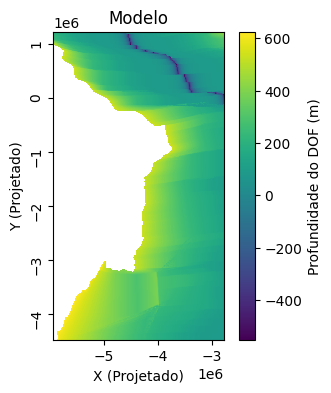

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rasterio
import pyproj
from rasterio.warp import reproject, Resampling

# Parâmetros do modelo de resfriamento condutivo
h0 = 2600  # Profundidade inicial do fundo oceânico em metros
k = 350  # Coeficiente empírico em m/Ma^0.5

# Modelo de subsidência térmica (Hillier & Watts, 2005)
def subsidencia_termica(idade):
    """Calcula a subsidência térmica baseada na idade da crosta oceânica."""
    h_infinito = 6400  # Profundidade assintótica (m)
    delta_h = 3200  # Diferença de profundidade (m)
    tau = 62  # Constante de tempo (Ma)
    return h_infinito - delta_h * np.exp(-idade / tau)

def calcular_dof(idade):
    """Calcula a profundidade do Normal Deep Ocean Floor (DOF) baseado na idade da crosta."""
    return h0 + k * np.sqrt(idade)

# Carregar grid de batimetria (Surfer v7 - Geosoft Grid)
with rasterio.open(filename_bat) as src:
    batimetria = src.read(1)  # Lê o primeiro band do grid
    transform = src.transform
    bounds = src.bounds
    perfil = src.profile  # Guarda o perfil para salvar a saída no mesmo formato

# Carregar grid de idade oceânica reprojetado
idade_grid = xr.open_dataset(filename_age_mercator)
idade = idade_grid["z"].copy()  # Garantir que a variável correta é usada

# Interpolar o grid de idade para coincidir com a batimetria
idade_interpolada = idade.interp(x=np.linspace(bounds.left, bounds.right, batimetria.shape[1]),
                                 y=np.linspace(bounds.bottom, bounds.top, batimetria.shape[0]),
                                 method="linear")

# Calcular subsidência térmica
subsidencia = subsidencia_termica(idade_interpolada)

# Calcular DOF ajustado pela subsidência térmica
DOF = calcular_dof(idade_interpolada) - subsidencia

# Criar dataset para exportação
DOF_grid = DOF.to_dataset(name="DOF")

# Salvar no formato Surfer v7 (ASCII Grid) compatível com Geosoft
DOF_grid.to_dataframe().reset_index().to_csv("DOF_grid.grd", sep=' ', index=False, header=False)

# Plot do modelo
plt.figure(figsize=(4, 4))
plt.pcolormesh(idade_interpolada.x, idade_interpolada.y, DOF, cmap='viridis', shading='nearest')
plt.gca().set_aspect('equal')
plt.colorbar(label="Profundidade do DOF (m)")
plt.title("Modelo")
plt.xlabel("X (Projetado)")
plt.xticks(rotation=0)
plt.ylabel("Y (Projetado)")
plt.yticks(rotation=90)
plt.show()

# **Mapa científico**

In [9]:
# Mapa científico

!pip install cmocean -q #(Thyng et al., 2016) http://tos.org/oceanography/assets/docs/29-3_thyng.pdf

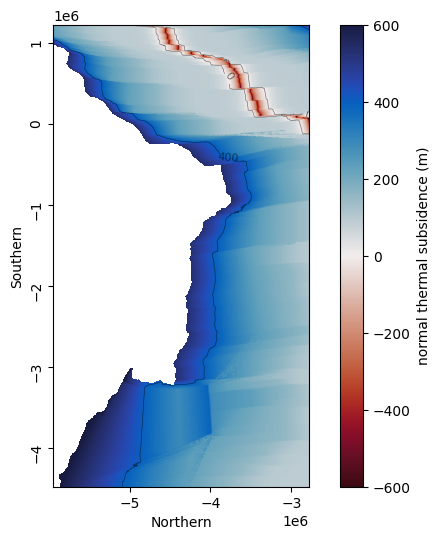

In [14]:
import cmocean

plt.figure(figsize=(8, 6))
plt.pcolormesh(idade_interpolada.x, idade_interpolada.y, DOF, cmap=cmocean.cm.balance_r, shading='nearest', vmax=600, vmin=-600)
plt.gca().set_aspect('equal')
plt.colorbar(label="normal thermal subsidence (m)")
#plt.title("Normal thermal subsidence")
plt.xlabel("Northern")
plt.xticks(rotation=0)
plt.ylabel("Southern")
plt.yticks(rotation=90)
contour_levels = [0, 400] #np.arange(np.nanmin(DOF), np.nanmax(DOF), 200)  # contorno
contours = plt.contour(idade_interpolada.x, idade_interpolada.y, DOF, levels=contour_levels, colors='black', linewidths=0.5, alpha=0.5)
plt.clabel(contours, inline=True, fontsize=8)
plt.show()